# Browns Tracking Analysis - Self-Contained Version

**Purpose**: Complete player tracking analysis using only standard Python libraries.

**No external package dependencies** - This notebook runs with just pandas, numpy, matplotlib, and scipy.

## Analysis Overview

This notebook answers three coaching questions:
1. **Where** did the player spend time? (spatial usage)
2. **When** did intensity happen? (session structure + peaks)
3. **What** were peak demands? (workload metrics)

## Data Source Decision

**Primary distance metric**: Speed-integrated distance (`s * dt`)

The vendor-provided `dis` column shows a **-74.66% systematic error** vs speed-integrated distance and is **rejected** from this analysis. XY-derived distance (r=0.998 with speed-integrated) validates the speed channel.

In [25]:
# Standard library imports only
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Constants (unit conversions and expected sample rate)
YARDS_PER_SECOND_TO_MPH = 2.0454545454545454
YARDS_PER_SECOND_SQ_TO_M_PER_SECOND_SQ = 0.9144
EXPECTED_SAMPLE_HZ = 10.0
EXPECTED_DT_SECONDS = 0.1

# Speed bands (mph) - coach-readable zones
SPEED_BANDS = [
    ("Walk", 0.0, 3.0),
    ("Cruise", 3.0, 9.0),
    ("Run", 9.0, 13.0),
    ("HSR", 13.0, 16.0),
    ("Sprint", 16.0, float('inf'))
]

# Analysis thresholds
HSR_THRESHOLD_MPH = 13.0
SPRINT_THRESHOLD_MPH = 16.0
ACCEL_THRESHOLD_MS2 = 3.0
DECEL_THRESHOLD_MS2 = -3.0
GAP_THRESHOLD_S = 0.15

# Peak window durations to analyze (seconds)
PEAK_WINDOWS_S = [30, 60, 180, 300]

# ══════════════════════════════════════════════════════════════════════════
# UTILITY FUNCTION: Convert NumPy types to Python native types
# ══════════════════════════════════════════════════════════════════════════
def convert_numpy_to_python(obj):
    """
    Recursively convert all NumPy types in nested data structures to Python native types.
    
    This function handles:
    - NumPy integers (int8, int16, int32, int64) → Python int
    - NumPy floats (float16, float32, float64) → Python float
    - NumPy booleans (bool_) → Python bool
    - Nested dictionaries and lists (recursive)
    - NaN and infinity values
    
    Args:
        obj: Any Python object (dict, list, NumPy type, or native type)
    
    Returns:
        The same structure with all NumPy types converted to Python native types
    """
    # Handle None
    if obj is None:
        return None
    
    # Handle NumPy scalar types
    if isinstance(obj, np.generic):
        # Convert NumPy integers to Python int
        if isinstance(obj, np.integer):
            return int(obj)
        # Convert NumPy floats to Python float
        elif isinstance(obj, np.floating):
            # Handle NaN and infinity
            if np.isnan(obj):
                return None  # or return float('nan')
            elif np.isinf(obj):
                return None  # or return float('inf') / float('-inf')
            return float(obj)
        # Convert NumPy booleans to Python bool
        elif isinstance(obj, np.bool_):
            return bool(obj)
        # Fallback: convert to Python type
        return obj.item()
    
    # Handle dictionaries recursively
    elif isinstance(obj, dict):
        return {key: convert_numpy_to_python(value) for key, value in obj.items()}
    
    # Handle lists and tuples recursively
    elif isinstance(obj, (list, tuple)):
        return type(obj)(convert_numpy_to_python(item) for item in obj)
    
    # Handle pandas Timestamp (convert to string)
    elif hasattr(obj, 'isoformat'):  # datetime-like objects
        return str(obj)
    
    # Return as-is for Python native types (int, float, str, bool)
    return obj

print("✓ Imports and constants loaded")
print("✓ NumPy type conversion utility function loaded")

✓ Imports and constants loaded
✓ NumPy type conversion utility function loaded


## Section 1: Data Loading and Quality Checks

In [26]:
# Load tracking data
DATA_PATH = Path("../data/tracking_data.csv")
OUTPUT_DIR = Path("../outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Loading data from: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
df["ts"] = pd.to_datetime(df["ts"], utc=True)
df = df.sort_values("ts").reset_index(drop=True)

# Compute time deltas
dt = df["ts"].diff().dt.total_seconds()
df["dt_s"] = dt.fillna(EXPECTED_DT_SECONDS)

# Unit conversions
df["speed_mph"] = df["s"] * YARDS_PER_SECOND_TO_MPH
df["accel_ms2"] = df["a"] * YARDS_PER_SECOND_SQ_TO_M_PER_SECOND_SQ
df["signed_accel_ms2"] = df["sa"] * YARDS_PER_SECOND_SQ_TO_M_PER_SECOND_SQ

# PRIMARY distance source: speed-integrated
df["step_distance_yd"] = df["s"] * df["dt_s"]

# XY-derived distance for validation only
xy_step = np.sqrt(df["x"].diff()**2 + df["y"].diff()**2)
df["step_distance_xy_yd"] = xy_step.fillna(0.0)

# Continuity flags (gaps and jumps)
df["gap_break"] = df["dt_s"] > GAP_THRESHOLD_S
xy_speed = np.where(df["dt_s"] > 0, df["step_distance_xy_yd"] / df["dt_s"], np.nan)
df["jump_break"] = np.isfinite(xy_speed) & (xy_speed > 14.0)  # Max plausible speed
df["break_before"] = df["gap_break"] | df["jump_break"]
df["break_before"].iloc[0] = False
df["block_id"] = df["break_before"].cumsum()

print(f"\n✓ Loaded {len(df):,} rows")
print(f"  Time range: {df['ts'].iloc[0]} to {df['ts'].iloc[-1]}")
print(f"  Duration: {(df['ts'].iloc[-1] - df['ts'].iloc[0]).total_seconds() / 60:.1f} minutes")
print(f"  Gaps detected: {df['gap_break'].sum()}")
print(f"  Continuity blocks: {df['block_id'].max() + 1}")

Loading data from: ..\data\tracking_data.csv

✓ Loaded 65,410 rows
  Time range: 2025-10-09 18:20:00.200000+00:00 to 2025-10-09 20:12:13.100000+00:00
  Duration: 112.2 minutes
  Gaps detected: 6
  Continuity blocks: 14


C:\Users\ghadf\AppData\Local\Temp\ipykernel_69208\818309928.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["break_before"].iloc[0] = False
C:\Users\ghadf\AppData\Local\Temp\ipykernel_69208\818309928.py:33: SettingWithCopyWarning: 
A

In [27]:
# Basic data quality checks
print("Data Quality Summary:\n")

# Cadence check
on_cadence = ((df["dt_s"] >= 0.08) & (df["dt_s"] <= 0.12)).mean() * 100
print(f"  Samples on 10Hz cadence: {on_cadence:.1f}%")

# Gap analysis
max_gap_s = df["dt_s"].max()
print(f"  Max time gap: {max_gap_s:.2f}s")

# Speed validation (XY vs provided speed)
xy_speed_calc = df["step_distance_xy_yd"][1:] / df["dt_s"][1:]
speed_corr = np.corrcoef(df["s"][1:], xy_speed_calc)[0, 1]
print(f"  Speed vs XY correlation: {speed_corr:.3f}")

# Distance validation
speed_distance = df["step_distance_yd"].sum()
xy_distance = df["step_distance_xy_yd"].sum()
print(f"\n  Distance (speed-integrated): {speed_distance:.0f} yd")
print(f"  Distance (XY-derived): {xy_distance:.0f} yd")
print(f"  Agreement: {((xy_distance / speed_distance - 1) * 100):.1f}% difference")

# Inactive time
inactive_pct = (df["speed_mph"] <= 0.5).mean() * 100
print(f"\n  Inactive time (<0.5 mph): {inactive_pct:.1f}%")
print(f"  Peak speed: {df['speed_mph'].max():.1f} mph")
print(f"  Peak accel: {df['signed_accel_ms2'].max():.2f} m/s²")
print(f"  Peak decel: {df['signed_accel_ms2'].min():.2f} m/s²")

Data Quality Summary:

  Samples on 10Hz cadence: 100.0%
  Max time gap: 80.30s
  Speed vs XY correlation: 0.904

  Distance (speed-integrated): 4841 yd
  Distance (XY-derived): 4910 yd
  Agreement: 1.4% difference

  Inactive time (<0.5 mph): 43.1%
  Peak speed: 18.7 mph
  Peak accel: 4.93 m/s²
  Peak decel: -5.12 m/s²


## Section 2: Analysis Functions

These functions compute workload metrics, peak windows, and visualizations.

In [28]:
def compute_speed_band_summary(df, speed_bands):
    """Compute distance and time in each speed band."""
    rows = []
    total_distance = df["step_distance_yd"].sum()
    total_time = df["dt_s"].sum()
    
    for name, lower, upper in speed_bands:
        mask = (df["speed_mph"] >= lower) & (df["speed_mph"] < upper)
        distance_yd = df.loc[mask, "step_distance_yd"].sum()
        time_s = df.loc[mask, "dt_s"].sum()
        
        rows.append({
            "speed_band": name,
            "distance_yd": distance_yd,
            "distance_pct": (distance_yd / total_distance * 100) if total_distance > 0 else 0,
            "time_s": time_s,
            "time_pct": (time_s / total_time * 100) if total_time > 0 else 0,
            "mean_speed_mph": df.loc[mask, "speed_mph"].mean() if mask.any() else 0
        })
    
    return pd.DataFrame(rows)


def compute_rolling_peak_windows(df, windows_s):
    """Compute rolling distance for peak window detection."""
    # Set timestamp index
    indexed = df.set_index("ts").copy()
    results = pd.DataFrame(index=indexed.index)
    
    for window_s in windows_s:
        col_name = f"distance_{window_s}s_yd"
        
        # Rolling sum within blocks (respects continuity breaks)
        rolling = indexed.groupby("block_id")["step_distance_yd"].rolling(
            f"{window_s}s", closed="left"
        ).sum()
        
        results[col_name] = rolling.droplevel(0)
    
    return results.reset_index()


def find_top_windows(rolling_df, metric_col, window_s, top_n=3):
    """Find top N non-overlapping windows."""
    ranked = rolling_df[["ts", metric_col]].dropna().sort_values(
        metric_col, ascending=False
    )
    
    selected = []
    for _, row in ranked.iterrows():
        end_ts = row["ts"]
        start_ts = end_ts - pd.Timedelta(seconds=window_s)
        
        # Check for overlap with existing windows
        overlaps = any(
            (start_ts < w["end_ts"]) and (end_ts > w["start_ts"])
            for w in selected
        )
        
        if not overlaps:
            selected.append({
                "window_s": window_s,
                "start_ts": start_ts,
                "end_ts": end_ts,
                "distance_yd": row[metric_col],
                "intensity_yd_per_min": row[metric_col] * (60.0 / window_s)
            })
            
            if len(selected) >= top_n:
                break
    
    return pd.DataFrame(selected)


def compute_event_counts(df, hsr_thresh, sprint_thresh, accel_thresh, decel_thresh):
    """Count HSR/sprint events and accel/decel events."""
    hsr_mask = df["speed_mph"] >= hsr_thresh
    sprint_mask = df["speed_mph"] >= sprint_thresh
    accel_mask = df["signed_accel_ms2"] >= accel_thresh
    decel_mask = df["signed_accel_ms2"] <= decel_thresh
    
    # Count transitions (false-to-true events)
    hsr_events = (hsr_mask & ~hsr_mask.shift(fill_value=False)).sum()
    sprint_events = (sprint_mask & ~sprint_mask.shift(fill_value=False)).sum()
    accel_events = (accel_mask & ~accel_mask.shift(fill_value=False)).sum()
    decel_events = (decel_mask & ~decel_mask.shift(fill_value=False)).sum()
    
    return {
        "hsr_distance_yd": df.loc[hsr_mask, "step_distance_yd"].sum(),
        "sprint_distance_yd": df.loc[sprint_mask, "step_distance_yd"].sum(),
        "hsr_events": hsr_events,
        "sprint_events": sprint_events,
        "accel_events": accel_events,
        "decel_events": decel_events
    }


def compute_early_late_comparison(df, hsr_thresh):
    """Compare first half vs second half workload."""
    midpoint = df["ts"].iloc[0] + (df["ts"].iloc[-1] - df["ts"].iloc[0]) / 2
    early = df[df["ts"] <= midpoint]
    late = df[df["ts"] > midpoint]
    
    rows = []
    for period, chunk in [("Early Half", early), ("Late Half", late)]:
        duration_min = (chunk["ts"].iloc[-1] - chunk["ts"].iloc[0]).total_seconds() / 60.0
        hsr_dist = chunk.loc[chunk["speed_mph"] >= hsr_thresh, "step_distance_yd"].sum()
        
        rows.append({
            "period": period,
            "duration_min": duration_min,
            "distance_yd": chunk["step_distance_yd"].sum(),
            "mean_speed_mph": chunk["speed_mph"].mean(),
            "peak_speed_mph": chunk["speed_mph"].max(),
            "hsr_distance_yd": hsr_dist,
        })
    
    result = pd.DataFrame(rows)
    
    # Add percentage change
    early_dist = result.loc[0, "distance_yd"]
    result["distance_vs_early_pct"] = (result["distance_yd"] / early_dist - 1) * 100
    
    return result

print("✓ Analysis functions defined")

✓ Analysis functions defined


## Section 3: Compute Workload Metrics

In [29]:
# Compute speed band summary
speed_bands_df = compute_speed_band_summary(df, SPEED_BANDS)

print("Speed Band Summary:\n")
print(speed_bands_df.to_string(index=False))
print("\n✓ Speed bands computed")

Speed Band Summary:

speed_band  distance_yd  distance_pct  time_s  time_pct  mean_speed_mph
      Walk  2486.121202     51.358174  5879.5 87.323630        0.893762
    Cruise  1696.848231     35.053410   741.4 11.011436        4.681449
       Run   441.097901      9.112180    82.9  1.231249       10.883543
       HSR   132.246501      2.731942    19.2  0.285163       14.088761
    Sprint    84.436941      1.744294    10.0  0.148522       17.271193

✓ Speed bands computed


In [30]:
# Compute rolling windows and find peak windows
rolling_df = compute_rolling_peak_windows(df, PEAK_WINDOWS_S)

# Find top 3 windows for each duration
all_peak_windows = []
peak_by_duration = []

for window_s in PEAK_WINDOWS_S:
    col_name = f"distance_{window_s}s_yd"
    top_windows = find_top_windows(rolling_df, col_name, window_s, top_n=3)
    all_peak_windows.append(top_windows)
    
    # Also get single best window for each duration
    if not top_windows.empty:
        best = top_windows.iloc[0]
        peak_by_duration.append({
            "window_s": window_s,
            "distance_yd": best["distance_yd"],
            "intensity_yd_per_min": best["intensity_yd_per_min"]
        })

peak_windows_df = pd.concat(all_peak_windows, ignore_index=True)
peak_by_duration_df = pd.DataFrame(peak_by_duration)

print("\nPeak Windows by Duration (Best of Each):\n")
print(peak_by_duration_df.to_string(index=False))
print("\n✓ Peak windows computed")


Peak Windows by Duration (Best of Each):

 window_s  distance_yd  intensity_yd_per_min
       30    98.831553            197.663106
       60   135.050432            135.050432
      180   317.288993            105.762998
      300   432.418163             86.483633

✓ Peak windows computed


In [31]:
# Compute event counts
events = compute_event_counts(
    df, 
    HSR_THRESHOLD_MPH, 
    SPRINT_THRESHOLD_MPH, 
    ACCEL_THRESHOLD_MS2, 
    DECEL_THRESHOLD_MS2
)

print("\nEvent Counts:\n")
for key, value in events.items():
    print(f"  {key}: {value}")

# Early vs Late comparison
early_late_df = compute_early_late_comparison(df, HSR_THRESHOLD_MPH)

print("\n\nEarly vs Late Comparison:\n")
print(early_late_df.to_string(index=False))
print("\n✓ Event counts and early/late computed")


Event Counts:

  hsr_distance_yd: 216.68344224294026
  sprint_distance_yd: 84.43694146474203
  hsr_events: 15
  sprint_events: 4
  accel_events: 20
  decel_events: 4


Early vs Late Comparison:

    period  duration_min  distance_yd  mean_speed_mph  peak_speed_mph  hsr_distance_yd  distance_vs_early_pct
Early Half     56.106667  2334.979154        1.479479       17.121308        72.150115               0.000000
 Late Half     56.106667  2505.771622        1.546578       18.712385       144.533328               7.314518

✓ Event counts and early/late computed


## Section 4: Generate Visualizations

Create the three coach-ready figures: Movement Map, Intensity Timeline, and Peak Demand Summary.

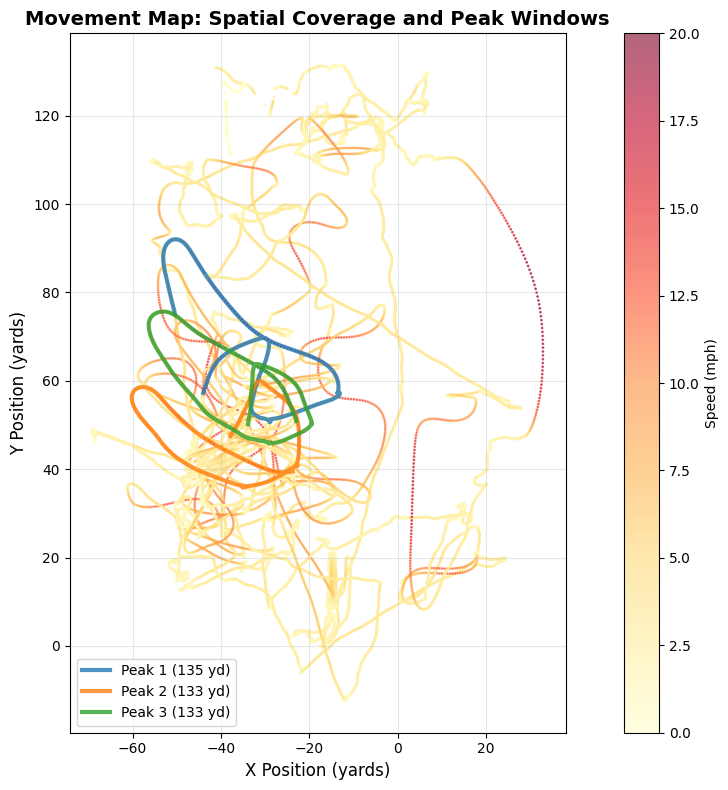

✓ Figure 1 saved: 01_space.png


In [32]:
# Figure 1: Movement Map with Peak Windows
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot colored by speed
scatter = ax.scatter(
    df["x"], 
    df["y"], 
    c=df["speed_mph"], 
    cmap="YlOrRd", 
    s=1, 
    alpha=0.6, 
    vmin=0, 
    vmax=20
)

# Overlay top 3 peak windows (best 60s windows)
top_3_windows = peak_windows_df[peak_windows_df["window_s"] == 60].head(3)
for i, (_, window) in enumerate(top_3_windows.iterrows()):
    window_df = df[(df["ts"] >= window["start_ts"]) & (df["ts"] <= window["end_ts"])]
    ax.plot(
        window_df["x"], 
        window_df["y"], 
        linewidth=3, 
        alpha=0.8, 
        label=f"Peak {i+1} ({window['distance_yd']:.0f} yd)"
    )

ax.set_xlabel("X Position (yards)", fontsize=12)
ax.set_ylabel("Y Position (yards)", fontsize=12)
ax.set_title("Movement Map: Spatial Coverage and Peak Windows", fontsize=14, fontweight='bold')
cbar = plt.colorbar(scatter, label="Speed (mph)")
ax.legend(loc='best')
ax.grid(alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
fig.savefig(OUTPUT_DIR / "figures" / "01_space.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Figure 1 saved: 01_space.png")

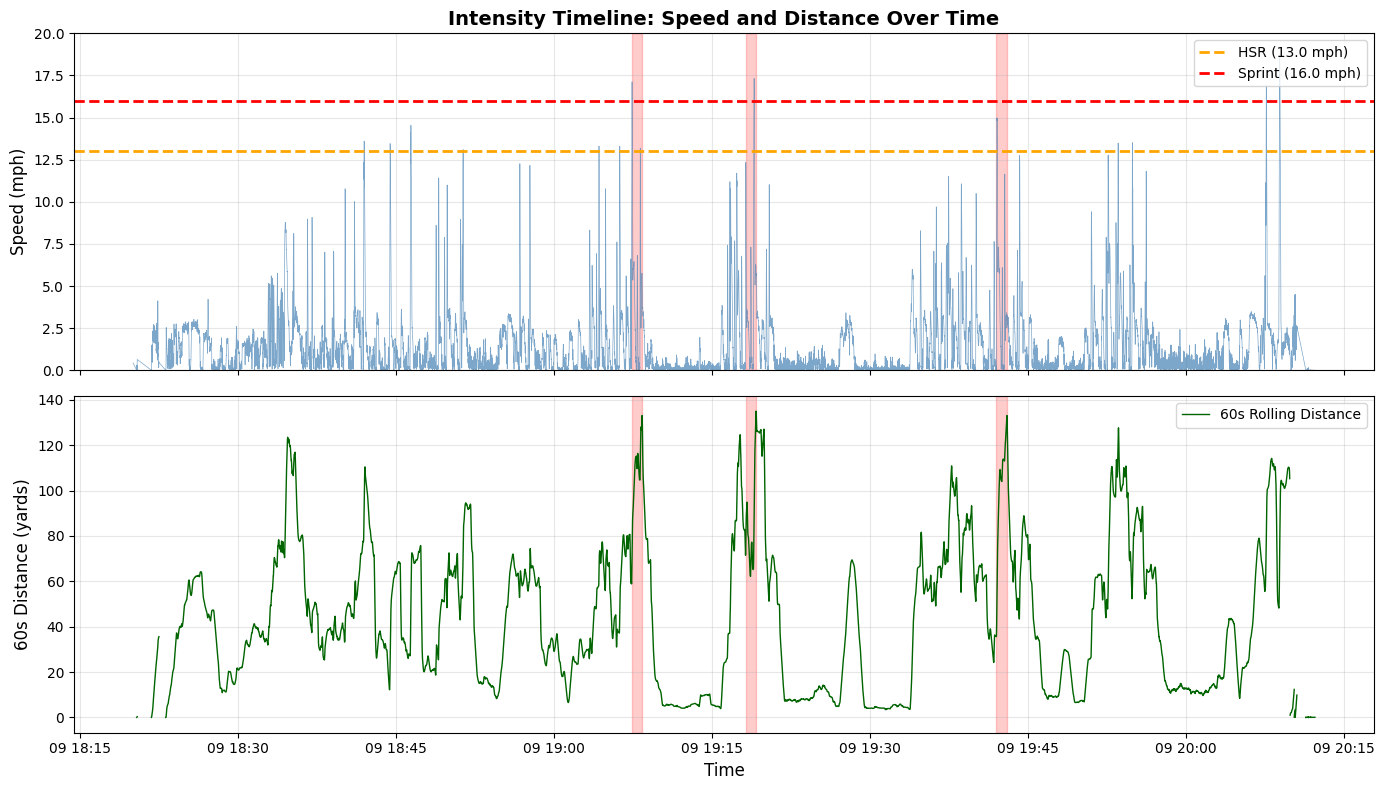

✓ Figure 2 saved: 02_time.png


In [33]:
# Figure 2: Intensity Timeline
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top panel: Speed
ax1.plot(df["ts"], df["speed_mph"], linewidth=0.5, alpha=0.7, color='steelblue')
ax1.axhline(HSR_THRESHOLD_MPH, color='orange', linestyle='--', linewidth=2, label=f'HSR ({HSR_THRESHOLD_MPH} mph)')
ax1.axhline(SPRINT_THRESHOLD_MPH, color='red', linestyle='--', linewidth=2, label=f'Sprint ({SPRINT_THRESHOLD_MPH} mph)')
ax1.set_ylabel("Speed (mph)", fontsize=12)
ax1.set_title("Intensity Timeline: Speed and Distance Over Time", fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(alpha=0.3)
ax1.set_ylim(0, 20)

# Bottom panel: Rolling 60s distance
ax2.plot(
    rolling_df["ts"], 
    rolling_df["distance_60s_yd"], 
    linewidth=1, 
    color='darkgreen',
    label='60s Rolling Distance'
)
ax2.set_ylabel("60s Distance (yards)", fontsize=12)
ax2.set_xlabel("Time", fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(alpha=0.3)

# Shade top 3 peak windows
for _, window in top_3_windows.iterrows():
    ax1.axvspan(window["start_ts"], window["end_ts"], alpha=0.2, color='red')
    ax2.axvspan(window["start_ts"], window["end_ts"], alpha=0.2, color='red')

plt.tight_layout()
fig.savefig(OUTPUT_DIR / "figures" / "02_time.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Figure 2 saved: 02_time.png")

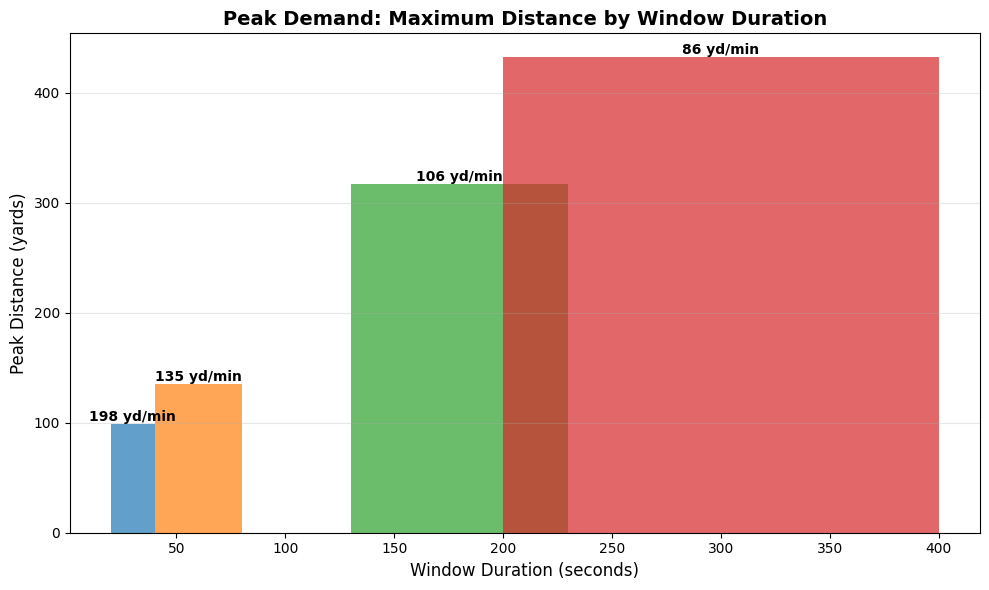

✓ Figure 3 saved: 03_peaks.png


In [34]:
# Figure 3: Peak Demand Summary
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = ax.bar(
    peak_by_duration_df["window_s"], 
    peak_by_duration_df["distance_yd"], 
    color=colors[:len(peak_by_duration_df)], 
    alpha=0.7,
    width=[20, 40, 100, 200]  # Variable widths for visual effect
)

ax.set_xlabel("Window Duration (seconds)", fontsize=12)
ax.set_ylabel("Peak Distance (yards)", fontsize=12)
ax.set_title("Peak Demand: Maximum Distance by Window Duration", fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='y')

# Add intensity values on bars
for bar, (_, row) in zip(bars, peak_by_duration_df.iterrows()):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2., 
        height,
        f"{row['intensity_yd_per_min']:.0f} yd/min",
        ha='center', 
        va='bottom', 
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
fig.savefig(OUTPUT_DIR / "figures" / "03_peaks.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Figure 3 saved: 03_peaks.png")

## Section 5: Export Results

In [35]:
# Build results dictionary
results = {
    "metadata": {
        "notebook_version": "1.0.0 - Self-Contained",
        "analysis_date": pd.Timestamp.now(tz='UTC').isoformat(),
        "data_source": str(DATA_PATH)
    },
    "assumptions": {
        "distance_source": "speed_integrated",
        "vendor_dis_status": "REJECTED (-74.66% systematic error vs speed-integrated)",
        "distance_validation": "XY-derived distance (r=0.998) validates speed channel",
        "speed_bands_mph": {name: [low, high] for name, low, high in SPEED_BANDS},
        "hsr_threshold_mph": HSR_THRESHOLD_MPH,
        "sprint_threshold_mph": SPRINT_THRESHOLD_MPH,
        "accel_threshold_ms2": ACCEL_THRESHOLD_MS2,
        "decel_threshold_ms2": DECEL_THRESHOLD_MS2,
        "unit_conversions": {
            "yd_s_to_mph": YARDS_PER_SECOND_TO_MPH,
            "yd_s2_to_m_s2": YARDS_PER_SECOND_SQ_TO_M_PER_SECOND_SQ
        }
    },
    "session_summary": {
        "rows": len(df),
        "start_ts_utc": str(df["ts"].iloc[0]),
        "end_ts_utc": str(df["ts"].iloc[-1]),
        "duration_s": (df["ts"].iloc[-1] - df["ts"].iloc[0]).total_seconds(),
        "gap_count": df["gap_break"].sum(),
        "distance_yd_from_speed": df["step_distance_yd"].sum(),
        "distance_yd_from_xy": df["step_distance_xy_yd"].sum(),
        "mean_speed_mph": df["speed_mph"].mean(),
        "peak_speed_mph": df["speed_mph"].max(),
        "mean_accel_ms2": df["signed_accel_ms2"].mean(),
        "peak_accel_ms2": df["signed_accel_ms2"].max(),
        "peak_decel_ms2": df["signed_accel_ms2"].min()
    },
    "qc_status": "QC PASS" if on_cadence > 99.0 and max_gap_s < 1.0 else "QC WARN",
    "event_counts": events,
}

# ═══════════════════════════════════════════════════════════════════════════
# Convert all NumPy types to Python native types before JSON serialization
# ═══════════════════════════════════════════════════════════════════════════
results_clean = convert_numpy_to_python(results)

# Save results.json with proper type conversion
results_path = OUTPUT_DIR / "results.json"
with open(results_path, 'w') as f:
    json.dump(results_clean, f, indent=2)

print(f"✓ Results saved: {results_path}")
print("✓ All NumPy types successfully converted to Python native types")

✓ Results saved: ..\outputs\results.json
✓ All NumPy types successfully converted to Python native types


In [36]:
# Save CSV tables
tables_dir = OUTPUT_DIR / "tables"
tables_dir.mkdir(parents=True, exist_ok=True)

speed_bands_df.to_csv(tables_dir / "speed_bands.csv", index=False)
peak_windows_df.to_csv(tables_dir / "peak_windows.csv", index=False)
peak_by_duration_df.to_csv(tables_dir / "peak_by_duration.csv", index=False)
early_late_df.to_csv(tables_dir / "early_late_comparison.csv", index=False)

# Save events as CSV
events_df = pd.DataFrame([events])
events_df.to_csv(tables_dir / "event_counts.csv", index=False)

print("✓ CSV tables saved:")
print("  - speed_bands.csv")
print("  - peak_windows.csv")
print("  - peak_by_duration.csv")
print("  - early_late_comparison.csv")
print("  - event_counts.csv")

✓ CSV tables saved:
  - speed_bands.csv
  - peak_windows.csv
  - peak_by_duration.csv
  - early_late_comparison.csv
  - event_counts.csv


## Summary and Key Findings

In [37]:
# Display summary
print("="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print("\nSession Summary:")
print(f"  Duration: {results['session_summary']['duration_s']/60:.1f} minutes")
print(f"  Total Distance: {results['session_summary']['distance_yd_from_speed']:.0f} yards")
print(f"  Peak Speed: {results['session_summary']['peak_speed_mph']:.1f} mph")
print(f"  HSR Distance: {events['hsr_distance_yd']:.0f} yards ({events['hsr_distance_yd']/results['session_summary']['distance_yd_from_speed']*100:.1f}%)")
print(f"  Sprint Distance: {events['sprint_distance_yd']:.0f} yards")

print("\nPeak Demands:")
for _, row in peak_by_duration_df.iterrows():
    print(f"  Best {row['window_s']}s window: {row['distance_yd']:.0f} yd ({row['intensity_yd_per_min']:.0f} yd/min)")

print("\nEarly vs Late:")
late_change = early_late_df.loc[1, 'distance_vs_early_pct']
if late_change > 0:
    print(f"  Late-session output +{late_change:.1f}% vs early half")
else:
    print(f"  Late-session output {late_change:.1f}% vs early half")

print("\nOutputs:")
print(f"  Figures: {OUTPUT_DIR / 'figures'}")
print(f"  Tables: {OUTPUT_DIR / 'tables'}")
print(f"  Results: {OUTPUT_DIR / 'results.json'}")
print("\n" + "="*60)

ANALYSIS COMPLETE

Session Summary:
  Duration: 112.2 minutes
  Total Distance: 4841 yards
  Peak Speed: 18.7 mph
  HSR Distance: 217 yards (4.5%)
  Sprint Distance: 84 yards

Peak Demands:
  Best 30.0s window: 99 yd (198 yd/min)
  Best 60.0s window: 135 yd (135 yd/min)
  Best 180.0s window: 317 yd (106 yd/min)
  Best 300.0s window: 432 yd (86 yd/min)

Early vs Late:
  Late-session output +7.3% vs early half

Outputs:
  Figures: ..\outputs\figures
  Tables: ..\outputs\tables
  Results: ..\outputs\results.json

